# 1. Introduction
Financial performance may be assessed by means of return on equity – ROE. Its main determinant factors suggested by literature are return on assets - ROA and own or financial leverage (FL). This paper provides a theoretical background and applied panel data analysis of two case studies that use fixed and random-effects models (investigating the influence of ROE of previous period on ROE for the current period). The selection of one of the two types of models is based on the results obtained by applying the Hausman test.

The theoretical relationship between ROE and (ROA, FL) is given as:
\begin{equation}
    ROE = (ROA + (ROA - d)\dot{} (1-p)\dot{} FL) \dot{}100
    \tag{1}
\end{equation}

where

\begin{align}
    ROE &= NI/EQ \tag{2}\\
    ROA &= OI/TA \tag{3}\\
    FL &= LT/EQ \tag{4}\\
    d &= \text{annual interest expense as \% of LT} \tag{5}\\
    p &= \text{tax rate as \% of income} \tag{6}
\end{align}

# 2. Data preparation

The dataset is retrieved from simfin via api, it includes the P\&L report (pnl) and Balance sheet (bal) of companies in the U.S. market in annual basis.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

api_key="free"
#"R7CKsNU1sh8A76ortiYKMeXzR4weHiQq"

#pd.read_csv("H:/Downloads/Nasdaq_2B.csv").iloc[1:100,1]
import simfin as sf
from simfin.names import *

# Set your API-key for downloading data.
sf.set_api_key(api_key)

# Set the local directory where data-files are stored.
# The dir will be created if it does not already exist.
sf.set_data_dir('~/simfin_data/')

# Load the annual Income Statements for all companies.
pnl = sf.load_income(variant='annual')
# load the Balance Sheet for all companies
bal = sf.load_balance(variant='annual', market='us')

Dataset "us-income-annual" on disk (32 days old).
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-balance-annual" on disk (32 days old).
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!


In [88]:
tickers = []

for ticker in pnl.index.get_level_values(0).unique():
    if len(pnl[(pnl.index.get_level_values(0) == ticker) & (pnl.index.get_level_values(1) >= '2008-01-01')]) >= 10 and ticker not in tickers:
        tickers.append(ticker) 

print("Number of tickers having at least 10 datapoints for time series (from 2008): ", len(tickers))

# create a dataframe containing relevant financial indicators
df = pd.DataFrame()

df["OI"] = pnl.loc[tickers][OPERATING_INCOME]
df["D"] = pnl.loc[tickers][INTEREST_EXP_NET]
df["NI"] = df["OI"] - df["D"]
df["EQT"] = bal.loc[tickers][TOTAL_EQUITY]
df["ROE"] = df["NI"]/df["EQT"]
df["TA"] = bal.loc[tickers][TOTAL_ASSETS]
df["ROA"] = df["OI"]/df["TA"]
df["DEBT"] = bal.loc[tickers][LT_DEBT]
df["FL"] = df["DEBT"]/df["EQT"]

df.dropna(inplace = True)

Number of tickers having at least 10 datapoints for time series (from 2008):  534


This study filters only the tickers with more than $(\geq)$ 10 entries for time dimension and concerns the period from 2008 to date. Descriptive statistics of the dataset is as in Table 1.

Text(0, 0.5, 'ROE')

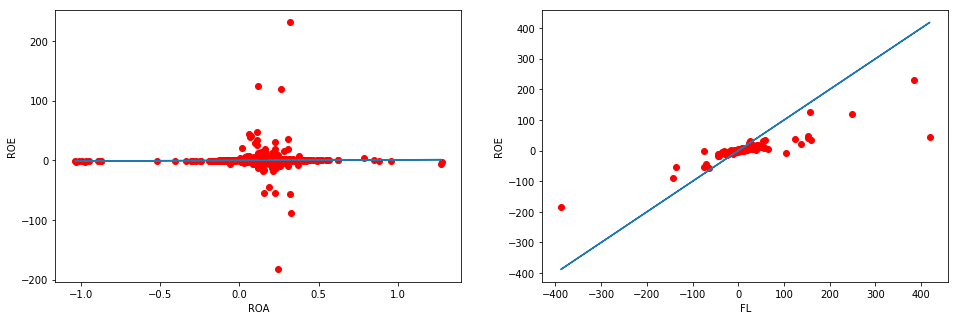

In [90]:
df.describe().transpose()

plt.subplots(figsize = (16,5))
plt.subplot(1,2,1)
plt.scatter(df["ROA"], df["ROE"], color = 'red')
plt.plot(df["ROA"],df["ROA"])
plt.xlabel('ROA')
plt.ylabel('ROE')

plt.subplot(1,2,2)
plt.scatter(df["FL"], df["ROE"], color = 'red')
plt.plot(df["FL"],df["FL"])
plt.xlabel('FL')
plt.ylabel('ROE')

## 2. Fixed effect model

Fixed effect model assumes a constant effect $\alpha_n$ is associated with each "member" of the group.

\begin{equation}
    ROE_{nt} = \beta_0 + \alpha_n + \delta_t + \beta_1ROA_{nt} + \beta_2FL_{nt} + \epsilon_{nt}
    \tag{2}
\end{equation}

where $\alpha_n$ denotes the cross-sectional fixed effects, $\delta_t$ represents temporal fixed effects and $\epsilon_{nt}$ is the error random variable.

The coefficients $\beta_1$ and $\beta_2$ are estimated based on the regression:

\begin{equation}
    (ROE_{nt} - \bar{ROE_n}) = (ROA_{nt} - \bar{ROA_n})\beta_1 + (FL_{nt} - \bar{FL_n})\beta_2
    \tag{3}
\end{equation}


In [78]:
# using package
from linearmodels import PanelOLS
import statsmodels.api as sm

mod = PanelOLS(df.iloc[:,4], sm.add_constant(df.iloc[:,[6,8]]), entity_effects=True)
res = mod.fit(cov_type='clustered', cluster_entity=True)

print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:                    ROE   R-squared:                        0.7627
Estimator:                   PanelOLS   R-squared (Between):              0.6058
No. Observations:                4820   R-squared (Within):               0.7627
Date:                Mon, Feb 03 2020   R-squared (Overall):              0.7509
Time:                        01:03:32   Log-likelihood                -1.154e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      6957.8
Entities:                        1912   P-value                           0.0000
Avg Obs:                       2.5209   Distribution:                  F(2,4329)
Min Obs:                       0.0000                                           
Max Obs:                       12.000   F-statistic (robust):             12.713
                            

C:\Users\Admin\AppData\Roaming\Python\Python36\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Intercept: 2.470008599258372e-17
ROA : 2.4868203906810873
 FL : 0.39049099889078337
R squared : 0.7627248451813438


Text(0.5, 1.0, 'Fitness of model')

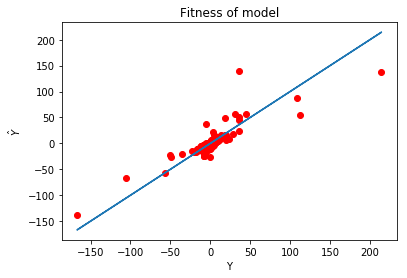

In [79]:
# sel-calculation
# calculate fixed effects estimator that is the average in time of each ticker's variables
data1 = df.reset_index()

fe = data1.groupby("Ticker").mean()[["ROE","ROA","FL"]]
fe.rename(columns = {"ROE": "avg_ROE", "ROA": "avg_ROA", "FL": "avg_FL"}, inplace = True)
data1 = data1.join(other = fe, on = "Ticker")

X = np.asarray([(data1["ROA"] - data1["avg_ROA"]).values,(data1["FL"] - data1["avg_FL"]).values]).transpose()
Y = np.asarray((data1["ROE"] - data1["avg_ROE"]).values)

from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X,Y)

residual = Y - reg.predict(X)
r_square = 1 - sum(residual**2)/sum((s - Y.mean())**2 for s in Y)

print('const: ' + str(reg.intercept_))
print('ROA : ' + str(reg.coef_[0]) + '\n FL : ' + str(reg.coef_[1]))
print('R squared : ' + str(r_square))

fe_roa = reg.coef_[0]
fe_fl = reg.coef_[1]

plt.scatter(Y, reg.predict(X),color = 'red')
plt.plot(Y, Y)
plt.xlabel('Y')
plt.ylabel(r'$\hat{Y}$')
plt.title('Fitness of model')

## 3. Random effects model

Random effect assumes randomness to the "intercept" associated with each "member" of the group. The "intercept" has variance $\sigma_u$.

\begin{equation}
    ROE = \beta_0 + \beta_1ROA + \beta_2 FL + u_n + v_t + w_{nt}
    \tag{4}
\end{equation}

where $u_n$ denotes individual random effects, $v_t$ denotes temporal random effects with variance $\sigma^2$ and $w_{nt}$ is the error component.

To employ random effect model, we first need to estimate a parameter to convert equation 2 to similar form with equation 3 when $\lambda = 1$.

\begin{equation}
    \lambda = 1 - \bigg(\frac{\sigma_w^2}{\sigma_w^2 + T\sigma_u^2}\bigg)^{1/2}
    \tag{5}
\end{equation}

The idea is that:
* when $\sigma_u^2 \to \infty$ then $\lambda \to 0$, the model becomes the general pooled OLS model.
* when $\sigma_u^2 \to 0$ then $\lambda \to 1$, the model becomes the Fixed effect model.

In [84]:
#using package
from linearmodels import RandomEffects

mod = RandomEffects(df.iloc[:,4], sm.add_constant(df.iloc[:,[6,8]]))
res = mod.fit()

print(res)

C:\Users\Admin\AppData\Roaming\Python\Python36\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                        RandomEffects Estimation Summary                        
Dep. Variable:                    ROE   R-squared:                        0.7514
Estimator:              RandomEffects   R-squared (Between):              0.6189
No. Observations:                4820   R-squared (Within):               0.7622
Date:                Mon, Feb 03 2020   R-squared (Overall):              0.7514
Time:                        01:20:23   Log-likelihood                -1.186e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      7278.9
Entities:                        1912   P-value                           0.0000
Avg Obs:                       2.5209   Distribution:                  F(2,4817)
Min Obs:                       0.0000                                           
Max Obs:                       12.000   F-statistic (robust):             7278.9
                            

lambda = 8.558140789816093e-06
ROA : 2.287326836756488
 FL : 0.38053090095702474
R squared : 0.7513788761675575


Text(0.5, 1.0, 'Fitness of model')

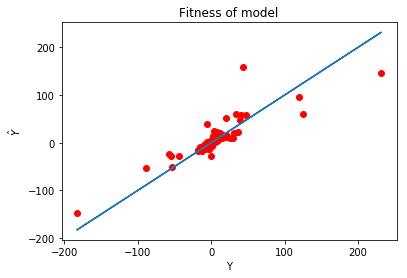

In [85]:
#self-calculation
T = len(df.index.get_level_values(1).unique())
n = len(df.index.get_level_values(0).unique())

data1["gr_avg_ROE"] = data1["avg_ROE"].unique().mean()
data1["sum_sqr_within"] = (data1["ROE"] - data1["avg_ROE"])**2
data1["sum_sqr_between"] = (data1["avg_ROE"] - data1["gr_avg_ROE"])**2

sigma_w_sqr = data1["sum_sqr_between"].sum()/2
sigma_u_sqr = data1["sum_sqr_within"].sum()/(T-1)/n - data1["sum_sqr_within"].sum()/n/(T*(n-1))

lam = 1-(sigma_w_sqr**2/(sigma_w_sqr**2 + (T-1)*sigma_u_sqr**2))**0.5

X = np.asarray([(data1["ROA"] - lam*data1["avg_ROA"]).values,(data1["FL"] - lam*data1["avg_FL"]).values]).transpose()
Y = np.asarray((data1["ROE"] - lam*data1["avg_ROE"]).values)

from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X,Y)

residual = Y - reg.predict(X)

r_square = 1 - sum(residual**2)/sum((s - Y.mean())**2 for s in Y)

print('lambda = ' + str(lam))
print('ROA : ' + str(reg.coef_[0]) + '\n FL : ' + str(reg.coef_[1]))
print('R squared : ' + str(r_square))

plt.scatter(Y, reg.predict(X),color = 'red')
plt.plot(Y, Y)
plt.xlabel('Y')
plt.ylabel(r'$\hat{Y}$')
plt.title('Fitness of model')

## 4. Hausman Test

In panel data, Hausman test evaluates the independency between "member" effect $\alpha_n$ and the regressors $X_n$, i.e. the endogeneity of the regressors. If $cov(\alpha_n, X_n) = 0$ then they are independent, it would be more persuasive to employ Random effect model than to do so with Fixed effect model.

The hypothesis test is:
\begin{equation}
    H_0: w = \frac{(\beta_{FE}-\beta_{RE})^2}{Var[\beta_{FE}]-Var[\beta_{RE}])} \sim \mathcal{X}^2_1
    \tag{6}
\end{equation}

when $\beta_{FE}-\beta_{RE}$ is small and $Var[\beta_{FE}]-Var[\beta_{RE}]$ large then the the two model parameters are consistent but the FE model produces greater errors $\to$ less efficient than RE model.

Test result shows that RE model is preferable to FE model in this case.

In [100]:
from linearmodels import IV2SLS

ivmod = IV2SLS(df.ROE, sm.add_constant(df.iloc[:,[6,8]]), None, None)
res_2sls = ivmod.fit()
print(res_2sls.summary)


                            OLS Estimation Summary                            
Dep. Variable:                    ROE   R-squared:                      0.7514
Estimator:                        OLS   Adj. R-squared:                 0.7513
No. Observations:                4820   F-statistic:                    27.570
Date:                Mon, Feb 03 2020   P-value (F-stat)                0.0000
Time:                        04:25:33   Distribution:                  chi2(2)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const         -0.2739     0.1029    -2.6622     0.0078     -0.4755     -0.0722
ROA            2.2873     0.6509     3.5143     0.00

C:\Users\Admin\AppData\Roaming\Python\Python36\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


# Reference

JABA, E., ROBU, I.B. and BALAN, C.B., Panel data analysis applied in financial performance assessment, Romanian Statistical Review (2017). [Link to access](http://www.revistadestatistica.ro/wp-content/uploads/2017/06/RRS-2_2017_A1.pdf?fbclid=IwAR22HvgVYSZL2oPP7LzXRDlZqsa8RnQYIEUPMm6lqlghzR0PXNS5c0YPloM)